In [27]:
# Import packages
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from adjustText import adjust_text

In [ ]:
# Import data from package
pbp = nfl.import_pbp_data(years=[2021])
weekly = nfl.import_weekly_data(([2022]), columns=None, downcast=True)
ngs_rec =  nfl.import_ngs_data(stat_type='receiving', years=[2022])
ngs_rush =  nfl.import_ngs_data(stat_type='rushing', years=[2022])
ngs_pass =  nfl.import_ngs_data(stat_type='passing', years=[2022])
pfr_rec =  nfl.import_pfr(s_type='rec', years=[2022])
pfr_rush =  nfl.import_pfr(s_type='rush', years=[2022])
pfr_pass =  nfl.import_pfr(s_type='pass', years=[2022])
snaps =  nfl.import_snap_counts(years=[2022])
seasonal = nfl.import_seasonal_data([2022])
seeweekly = nfl.see_weekly_cols()
seePBP = nfl.see_pbp_cols()
ids = nfl.import_ids()

In [24]:
# Drop special teams plays
pbp = nfl.import_pbp_data([2022])
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])
pbp_rp.head()

2022 done.
Downcasting floats.


C:\Users\corla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nfl_data_py\__init__.py:137: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plays.loc[:, cols] = plays.loc[:, cols].astype(numpy.float32)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SHOTGUN,"1 RB, 2 TE, 2 WR",6.0,"3 DL, 4 LB, 4 DB",4.0,53536;43586;42371;53443;42500;44999;43433;3309...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
5,136.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",4.0,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
7,202.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,SINGLEBACK,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",3.0,44929;43362;47906;42467;46211;43301;54469;4788...,00-0033118;00-0034978;00-0034753;00-0031330;00...,00-0033463;00-0032109;00-0034384;00-0032759;00...,11,11


In [26]:
# Create reciever yac DF
receiver_yac = pbp_rp[(pbp_rp['pass'] == 1)].groupby(['receiver_player_name', 'posteam']).agg({'pass': 'count', 
        'yards_after_catch': 'sum'}).reset_index().rename(columns = {'pass' : 'targets', 'yards_after_catch' : 'yac', 'posteam' : 'team'})
receiver_yac = receiver_yac[(receiver_yac['targets'] >= 100)]
receiver_yac.sort_values('yac', inplace = True)
receiver_yac.head()

,receiver_player_name,team,targets,yac
92,C.Sutton,DEN,109,152.0
183,G.Davis,BUF,106,153.0
26,A.Thielen,MIN,113,157.0
138,D.Moore,CAR,118,182.0
85,C.Olave,NO,120,210.0


In [20]:
# Dictionary to create image color dots
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

Text(0.8, 0.06, 'Data: nflfastR')

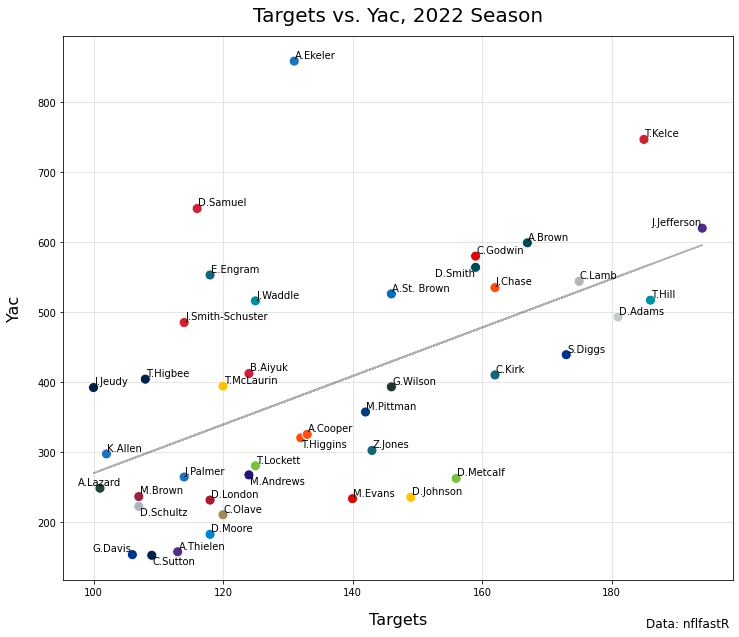

In [32]:
# Create a figure
fig, ax = plt.subplots(figsize=(12,10))

# Map the COLORS dictionary to the posteam column
receiver_yac['color'] = receiver_yac['team'].map(COLORS)

# Create the scatterplot
sns.scatterplot(x = receiver_yac.targets, y = receiver_yac.yac, c = receiver_yac.color,s=100)

# Add labels to each data point
texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
    receiver_yac.targets, receiver_yac.yac, receiver_yac.receiver_player_name)]

adjust_text(texts)

# Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

# Add trend line
m, b = np.polyfit(receiver_yac.targets, receiver_yac.yac, 1)

plt.plot(receiver_yac.targets, m*receiver_yac.targets + b, 'k', alpha=.3,linestyle='-')

# Add title, labels, and cite the data source
ax.set_title('Targets vs. Yac, 2022 Season',fontsize=20,pad=15)
ax.set_xlabel('Targets',fontsize=16,labelpad=15)
ax.set_ylabel('Yac',fontsize=16,labelpad=15)
plt.figtext(.8,.06,'Data: nflfastR',fontsize=12)